In [1]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
# from scipy.ndimage.filters import gaussian_filter 
from scipy.ndimage import gaussian_filter
import scipy
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
%matplotlib inline

In [2]:
# this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    # SỬA LỖI ZIP/KDTree:
    # Chuyển từ (hàng, cột) sang danh sách tọa độ (cột, hàng) hay (x, y)
    # Cách 1: Dùng list(zip(...))
    # pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    # Cách 2: Dùng np.stack (khuyến nghị)
    loc = np.nonzero(gt)
    pts = np.stack((loc[1], loc[0]), axis=1) # pts giờ là mảng (N, 2) gồm các tọa độ (x, y)
    
    leafsize = 2048
    # build kdtree
    # Kiểm tra xem pts có rỗng không (mặc dù đã check gt_count > 0)
    if pts.shape[0] > 0:
        tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
        # query kdtree
        distances, locations = tree.query(pts, k=4)
    
        print('generate density...')
        for i, pt in enumerate(pts):
            pt2d = np.zeros(gt.shape, dtype=np.float32)
            pt2d[pt[1],pt[0]] = 1.
            if gt_count > 1:
                sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
            else:
                sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
            
            # SỬA LỖI DEPRECATION:
            # Bỏ .filters
            density += gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    return density

In [3]:
#set the root to the Shanghai dataset you download
root = 'data/'

In [4]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_train,part_A_test]

In [5]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [6]:
for img_path in img_paths:
    print(img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

data/part_A_final/train_data\images\IMG_1.jpg
(768, 1024)
generate density...
done.
data/part_A_final/train_data\images\IMG_10.jpg
(683, 1024)
generate density...
done.
data/part_A_final/train_data\images\IMG_100.jpg
(654, 1024)
generate density...
done.
data/part_A_final/train_data\images\IMG_101.jpg
(768, 1024)
generate density...
done.
data/part_A_final/train_data\images\IMG_102.jpg
(768, 1024)
generate density...
done.
data/part_A_final/train_data\images\IMG_103.jpg
(400, 400)
generate density...
done.
data/part_A_final/train_data\images\IMG_104.jpg
(405, 540)
generate density...
done.
data/part_A_final/train_data\images\IMG_105.jpg
(632, 990)
generate density...
done.
data/part_A_final/train_data\images\IMG_106.jpg
(675, 1024)
generate density...
done.
data/part_A_final/train_data\images\IMG_107.jpg
(517, 800)
generate density...
done.
data/part_A_final/train_data\images\IMG_108.jpg
(767, 1024)
generate density...
done.
data/part_A_final/train_data\images\IMG_109.jpg
(681, 1024)
g

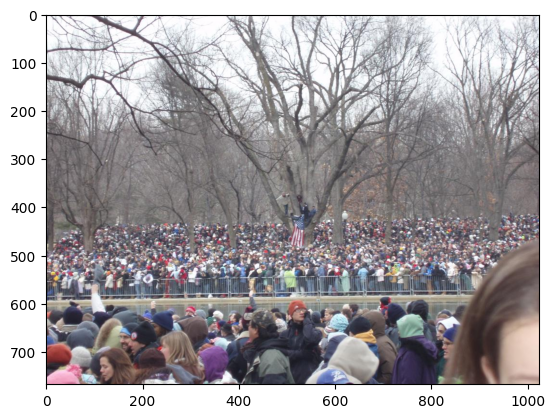

In [7]:
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_paths[0]))

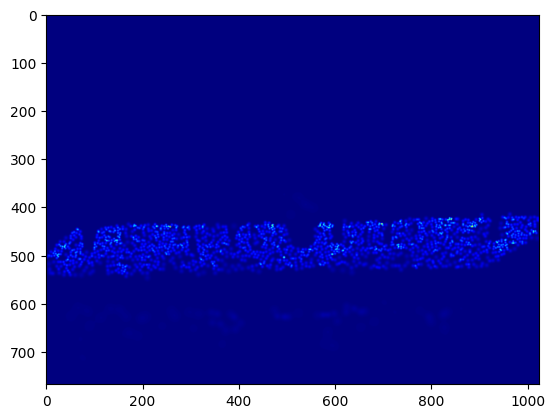

In [8]:
gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [9]:
np.sum(groundtruth)# don't mind this slight variation

np.float32(1543.841)

In [10]:
#now generate the ShanghaiB's ground truth
path_sets = [part_B_train,part_B_test]

In [11]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [12]:
for img_path in img_paths:
    print(img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter(k,15)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

data/part_B_final/train_data\images\IMG_1.jpg
data/part_B_final/train_data\images\IMG_10.jpg
data/part_B_final/train_data\images\IMG_100.jpg
data/part_B_final/train_data\images\IMG_101.jpg
data/part_B_final/train_data\images\IMG_102.jpg
data/part_B_final/train_data\images\IMG_103.jpg
data/part_B_final/train_data\images\IMG_104.jpg
data/part_B_final/train_data\images\IMG_105.jpg
data/part_B_final/train_data\images\IMG_106.jpg
data/part_B_final/train_data\images\IMG_107.jpg
data/part_B_final/train_data\images\IMG_108.jpg
data/part_B_final/train_data\images\IMG_109.jpg
data/part_B_final/train_data\images\IMG_11.jpg
data/part_B_final/train_data\images\IMG_110.jpg
data/part_B_final/train_data\images\IMG_111.jpg
data/part_B_final/train_data\images\IMG_112.jpg
data/part_B_final/train_data\images\IMG_113.jpg
data/part_B_final/train_data\images\IMG_114.jpg
data/part_B_final/train_data\images\IMG_115.jpg
data/part_B_final/train_data\images\IMG_116.jpg
data/part_B_final/train_data\images\IMG_117.